For this exercise, you may need to install the `networkx` and `skimage` modules in your local environment.

In [2]:
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from networkx import grid_graph
%pylab inline
%load_ext autoreload
%autoreload 2

from cvf20.unionfind import UnionFind as UF

Populating the interactive namespace from numpy and matplotlib


# 1 Maze Generation with Kruskal's algorithm

Finish the implementation in the code block below:

In [6]:
# Dimension of the generated maze:
field_shape = (16, 16) 

# make a union find datastructure for all nodes
uf = UF()
for x in range(field_shape[0]):
    for y in range(field_shape[1]):
        uf.add((x,y))

# Create a gridgraph:
# - Nodes are given by a tuple of 2D coordinates representing the position of the pixel in the image, e.g. (2,4)
# - Edges are given by a tuple of two nodes, e.g. ((0,1), (0,2))
G = grid_graph(dim=list(field_shape))

# Create random weights
edge_weights = np.array([[e, random.rand()] for e in G.edges()]) # shape (nb_edges, 2)
for e, weight in edge_weights:
    G[e[0]][e[1]]['weight'] = weight
nodes = [n for n in G.nodes()]

    
# We will add edges to the list 
MST = []
# that make up the minimal spanning tree
exit = (field_shape[0]-1, field_shape[1]-1)
start = (0, 0)
ordered_edges = [e for e, w in sorted(edge_weights, key=lambda x: x[1])]
for n in nodes:
    uf.add(n)
for e in ordered_edges:
    if not uf.find(e[0]) == uf.find(e[1]):
        MST.append(e)
        uf.union(e[0], e[1])

print(uf.connected(start, exit))

True


And then test it by plotting the created maze:

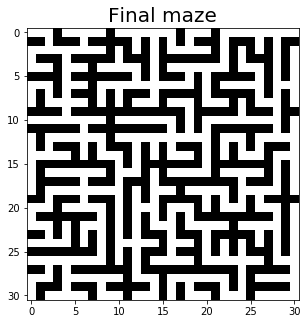

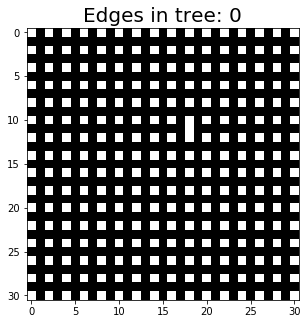

In [7]:
from matplotlib import animation
from IPython.display import HTML

def visualize_MSTs(MST):
    
    maze = np.zeros([len(MST)+20]+[2*f for f in field_shape])
    maze[:, :-1:2, :-1:2] = 1
    
    for i,(n1, n2) in enumerate(MST):
        n1 = np.asarray(n1)
        n2 = np.asarray(n2)
        w1 = n1 + 0.5*(n2-n1)
        maze[i:, int(2*w1[0]), int(2*w1[1])] = 1
    return maze

maze = visualize_MSTs(MST)

# Visualize final maze:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(maze[-1, :-1, :-1], cmap='gray')
ax.set_title("Final maze", fontsize=20)
# ax.set_axis_off()
plt.show()

# Animate Maze creation:
fig, ax = plt.subplots(figsize=(5, 5))

def update(i):
    ax.imshow(maze[i, :-1, :-1], cmap='gray')
    ax.set_title("Edges in tree: {}".format(i), fontsize=20)
    return (ax, )
    
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, len(MST), 4), interval=200)

# Display the animation in the notebook:
HTML(anim.to_html5_video())

In [10]:
# Save animation to file:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=1800)

anim.save('im.mp4', writer=writer)

### 1b) Modification for an unsolvable maze:
Insert your code below

In [17]:
# Dimension of the generated maze:
field_shape = (16, 16) 

# make a union find datastructure for all nodes
uf = UF()
for x in range(field_shape[0]):
    for y in range(field_shape[1]):
        uf.add((x,y))

# Create a gridgraph:
# - Nodes are given by a tuple of 2D coordinates representing the position of the pixel in the image, e.g. (2,4)
# - Edges are given by a tuple of two nodes, e.g. ((0,1), (0,2))
G = grid_graph(dim=list(field_shape))

# Create random weights
edge_weights = np.array([[e, random.rand()] for e in G.edges()]) # shape (nb_edges, 2)
for e, weight in edge_weights:
    G[e[0]][e[1]]['weight'] = weight
nodes = [n for n in G.nodes()]

    
# We will add edges to the list 
MST = []
# that make up the minimal spanning tree
exit = (field_shape[0]-1, field_shape[1]-1)
start = (0, 0)
ordered_edges = [e for e, w in sorted(edge_weights, key=lambda x: x[1])]
for n in nodes:
    uf.add(n)
for e in ordered_edges:
    if not uf.find(e[0]) == uf.find(e[1]):
        if uf.connected(start, e[0]) and uf.connected(exit, e[1]) or uf.connected(start, e[1]) and uf.connected(exit, e[0]):
            continue
        MST.append(e)
        uf.union(e[0], e[1])

print(uf.connected(start, exit))

False


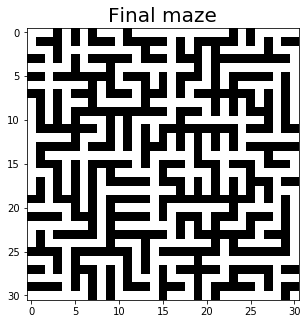

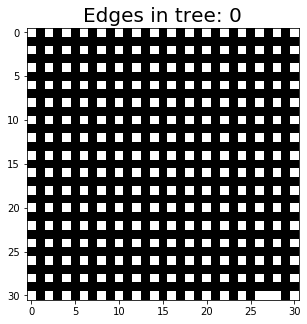

In [18]:
from matplotlib import animation
from IPython.display import HTML

def visualize_MSTs(MST):
    
    maze = np.zeros([len(MST)+20]+[2*f for f in field_shape])
    maze[:, :-1:2, :-1:2] = 1
    
    for i,(n1, n2) in enumerate(MST):
        n1 = np.asarray(n1)
        n2 = np.asarray(n2)
        w1 = n1 + 0.5*(n2-n1)
        maze[i:, int(2*w1[0]), int(2*w1[1])] = 1
    return maze

maze = visualize_MSTs(MST)

# Visualize final maze:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(maze[-1, :-1, :-1], cmap='gray')
ax.set_title("Final maze", fontsize=20)
# ax.set_axis_off()
plt.show()

# Animate Maze creation:
fig, ax = plt.subplots(figsize=(5, 5))

def update(i):
    ax.imshow(maze[i, :-1, :-1], cmap='gray')
    ax.set_title("Edges in tree: {}".format(i), fontsize=20)
    return (ax, )
    
anim = animation.FuncAnimation(fig, update, frames=np.arange(0, len(MST), 4), interval=200)

# Display the animation in the notebook:
HTML(anim.to_html5_video())

# 2. Cell Segmentation with the Watershed Algorithm

### Load and plot input data

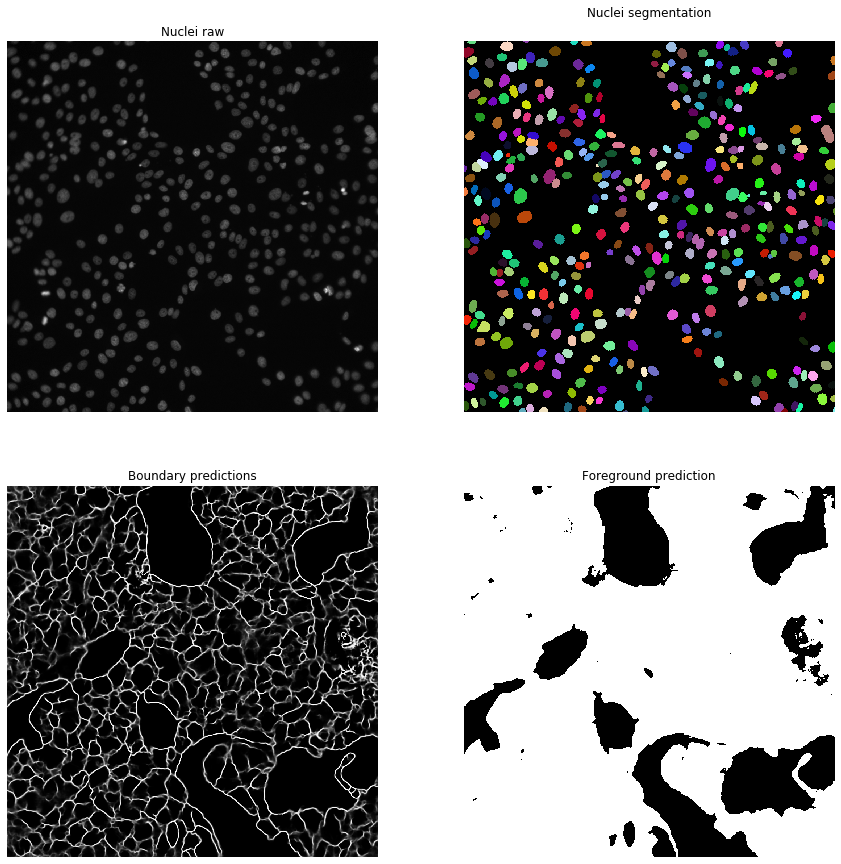

In [63]:
from cvf20.utils import readHDF5, plot_segm

filename = "./data/serum_data.h5"

boundaries = readHDF5(filename, "boundaries")
serum_IgA = readHDF5(filename, "serum_IgA")
foreground = readHDF5(filename, "foreground_prediction")
nuclei_segmentation = readHDF5(filename, "nuclei_segmentation")
nuclei_raw = readHDF5(filename, "nuclei_raw")


cmap="gray"

f, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
ax[0,0].imshow(nuclei_raw, cmap=cmap) 
ax[0,0].axis('off')
ax[0,0].set_title("Nuclei raw")
plot_segm(ax[0,1], nuclei_segmentation)
ax[0,1].axis('off')
ax[0,1].set_title("Nuclei segmentation")
ax[1,0].imshow(boundaries, cmap=cmap)
ax[1,0].axis('off')
ax[1,0].set_title("Boundary predictions")
ax[1,1].imshow(foreground, cmap=cmap) 
ax[1,1].axis('off')
ax[1,1].set_title("Foreground prediction")

plt.show()

### Your code goes here 

In [72]:
from skimage.segmentation import watershed
WS_segm = watershed(image = boundaries, mask = foreground == 1)

In [73]:
from skimage.segmentation import watershed

seeded_WS_segm = watershed(image = boundaries, markers = nuclei_segmentation, mask = foreground == 1)

### Plot your results

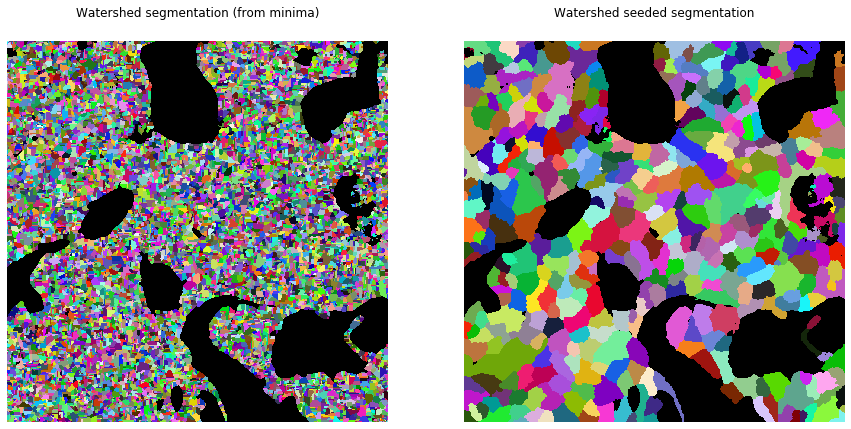

In [74]:
if seeded_WS_segm is not None and WS_segm is not None:
    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,15))
    plot_segm(ax[0], WS_segm)
    ax[0].axis('off')
    ax[0].set_title("Watershed segmentation (from minima)")
    plot_segm(ax[1], seeded_WS_segm)
    ax[1].axis('off')
    ax[1].set_title("Watershed seeded segmentation")
    plt.show()

One directly notices that the amount of generated seeds using the local minima of the image exceeds the amount of seeds using the segmented nuclei by far. This could be avoided by taking the local minima of a greater vicinity, which stands in direct trade-off with the risk of merging cells, because there may simply not be enough seeds. Here the seeds generated by taking the local minima do not represent nuclei and therefore components generated by the watershed algorithm do not correspond to cells. In contrast the components of the approach using the segmented nuclei do correspond to cells, because the number of seed approximately matches the number of cells (ofc not perfectly, see bottom left corner) and the detected cell boundaries work well as weights by nature.

# 3. Mutex Watershed

Once you have finished implementing the Mutex Watershed algorithm in `cvf20/mws_python.py`, run the next block to test your implementation.

Running mutex_watershed...
Adapted rand score: 0.8608358827616343; Precision: 0.9469346335325345; Recall: 0.7890890299970277


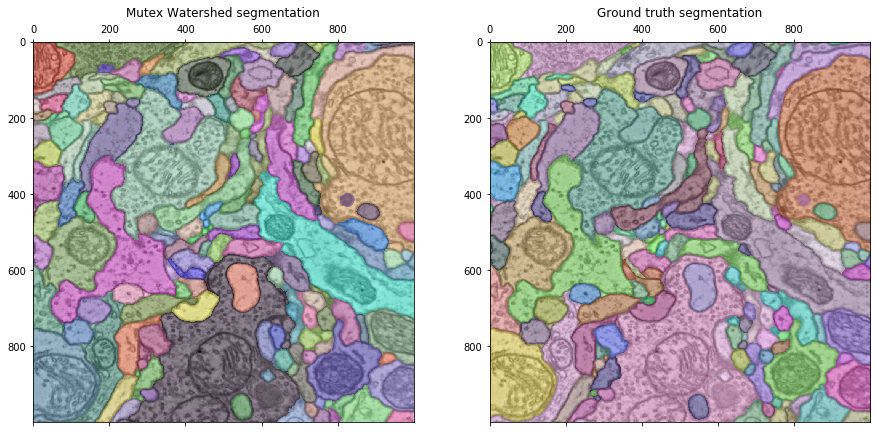

In [77]:
from cvf20.mws_python import MWS
from cvf20.arand import adapted_rand
import time
import h5py
import networkx as nx

# Load graph weights from file:
# - each edge is given by a tuple of two node IDs (u, v)
with h5py.File("./data/cremi_data.h5", "r") as h:
    raw = h["raw"][:]
    gt = h["gt"][:]
    sp = h["sp"][:]
    edge_costs = -h["edge_costs"][:]
    edges = h["edges"][:]
    raw = h["raw"][:]

# Build graph in Networkx:
g = nx.Graph()
for i, (u, v) in enumerate(edges):
    g.add_edge(u, v, w=edge_costs[i])

print("Running mutex_watershed...")
mws_seg = np.asarray(MWS(g, edges, edge_costs))


# Compute scores:
ar, prec, recall = adapted_rand(mws_seg[sp], gt)
print("Adapted rand score: {}; Precision: {}; Recall: {}".format(ar, prec, recall))


# Plot the results:
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(15,15))
plot_segm(ax[0],mws_seg[sp], with_background_label=False, alpha_labels=0.4, background_image=raw)
ax[0].set_title("Mutex Watershed segmentation")
plot_segm(ax[1],gt, with_background_label=False, alpha_labels=0.4, background_image=raw)
ax[1].set_title("Ground truth segmentation")
plt.show()